# Information Retrieval I #
## Assignment 2: retrieval models [100 points + 10 bonus points] ##
**TA**: Christophe Van Gysel (cvangysel@uva.nl; C3.258B, Science Park 904)

**Secondary TAs**: Harrie Oosterhuis, Nikos Voskarides

In this assignment you will get familiar with basic information retrieval concepts. You will implement and evaluate different information retrieval ranking models and evaluate their performance.

We provide you with a VirtualBox image that comes pre-loaded with an index and a Python installation. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-two assignment**, the deadline is **23:59 - 25 January, 2017**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](https://piazza.com/class/ixoz63p156g1ts).

### Technicalities (must-read!) ###
This assignment comes pre-loaded on a VirtualBox running Ubuntu. We have configured the indexing software and Python environment such that it works out of the box. You are allowed to extract the files from the VirtualBox and set-up your own non-virtualized environment. However, in this case you are on your own w.r.t. software support.

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.
      
`Python + Jupyter`, `Indri`, `Gensim` and `Pyndri` come pre-installed (see `$HOME/.local`). TREC Eval can be found in `$HOME/Downloads/trec_eval.9.0`. The password of the `student` account on the VirtualBox is `datascience`.

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [1]:
import logging
import sys

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [2]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [3]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [4]:
example_document = index.document(index.document_base())
print(example_document, 'lol')

('AP890425-0001', (1360, 192, 363, 0, 880, 0, 200, 0, 894, 412, 92160, 3, 192, 0, 363, 34, 1441, 0, 174134, 0, 200, 0, 894, 412, 2652, 0, 810, 107, 49, 4903, 420, 0, 1, 48, 35, 489, 0, 35, 687, 192, 243, 0, 249311, 1877, 0, 1651, 1174, 0, 2701, 117, 412, 0, 810, 391, 245233, 1225, 5838, 16, 0, 233156, 3496, 0, 393, 17, 0, 2435, 4819, 930, 0, 0, 200, 0, 894, 0, 22, 398, 145, 0, 3, 271, 115, 0, 1176, 2777, 292, 0, 725, 192, 0, 0, 50046, 0, 1901, 1130, 0, 192, 0, 408, 0, 243779, 0, 0, 553, 192, 0, 363, 0, 3747, 0, 0, 0, 0, 1176, 0, 1239, 0, 0, 1115, 17, 0, 0, 585, 192, 1963, 0, 0, 412, 54356, 0, 773, 0, 0, 0, 192, 0, 0, 1130, 0, 363, 0, 545, 192, 0, 1174, 1901, 1130, 0, 4, 398, 145, 39, 0, 577, 0, 355, 0, 491, 0, 6025, 0, 0, 193156, 88, 34, 437, 0, 0, 1852, 0, 828, 0, 1588, 0, 0, 0, 2615, 0, 0, 107, 49, 420, 0, 0, 190, 7, 714, 2701, 0, 237, 192, 157, 0, 412, 34, 437, 0, 0, 200, 6025, 26, 0, 0, 0, 0, 363, 0, 22, 398, 145, 0, 200, 638, 126222, 6018, 0, 880, 0, 0, 161, 0, 0, 319, 894, 2701, 

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens mean we take a look at the dictionary of the index:

In [5]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:15])

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time')]


Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [6]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [7]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [8]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

Document AP890425-0001 has 13 word matches with query: "university  massachusetts".
Document AP890425-0001 and query "university  massachusetts" have a 2.5% overlap.


While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [9]:
import collections
import io
import logging
import sys

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))

OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poaching'), ('78', 'Greenpeace'

### Task 1: Implement and compare lexical IR methods [45 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html). **[5 points]**
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.2, ..., 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, ..., 2000]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.2, ..., 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[10 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

1) Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**)

In [10]:
import pyndri
import numpy as np

added_word = []
query_set= set()
#dictionary of document id to dictionnary of word index to word frequency{doc_id,{word_id, word_frequency}}
doc_terms_frequency = {}
nb_words_in_doc={}
#number of unique words in document
nb_distinct_words_in_doc = {}
#number of document in which the word appears / total number of documents
document_frequency={}
total_document_nb=(index.maximum_document()-index.document_base())
#total number of occurence of a term in the collection
collection_frequency={}
total_collection_words=0 

#create the set of query words
with open('./ap_88_89/topics_title', 'r') as f_topics:
    for key, value in parse_topics([f_topics]).items():
        for token in index.tokenize(value):
            token_id= token2id.get(token,0)
            if token_id>0:
                query_set.add(token_id)
                
print(len(query_set)*(index.maximum_document()-index.document_base()))
i=0
for document_id in range(index.document_base(), index.maximum_document()):
    doc = index.document(document_id)
    for word_id in doc[1]:
        if(i%10000000==0):
            print(i)
        if word_id in query_set:
            #calculate document frequency 
            if word_id not in added_word:
                if word_id not in document_frequency:
                    document_frequency[word_id]=1
                else:
                    document_frequency[word_id]+=1
                added_word.append(word_id)
            #calculate terms frequency 
            if document_id not in doc_terms_frequency:
                doc_terms_frequency[document_id]={}
                doc_terms_frequency[document_id][word_id]=1
            else:
                if word_id not in  doc_terms_frequency[document_id]:
                    doc_terms_frequency[document_id][word_id]=1
                else:
                    doc_terms_frequency[document_id][word_id]+=1
            #calculate collection_frequency
            if word_id not in  collection_frequency:
                collection_frequency[word_id]=1
            else: 
                collection_frequency[word_id]+=1
        
        i+=1
    total_collection_words+=len(doc[1])
    nb_words_in_doc[document_id]=len(doc[1])
    nb_distinct_words_in_doc[document_id]=len(set(doc[1]))     
    
#reset added_word for memory reason: it is not used anymore 
added_word=[]

average_doc_length = 0
def calculate_avg_length():
    average_doc_length = 0
    total_doc_length = 0
    for document_id in range(index.document_base(), index.maximum_document()):
        doc = index.document(document_id)
        total_doc_length += len(doc[1])
    average_doc_length = total_doc_length / float(index.maximum_document() - index.document_base())
    return average_doc_length
average_doc_length = calculate_avg_length()
print(average_doc_length)

75056232
0
10000000
20000000
30000000
40000000
50000000
60000000
70000000
461.63406987976697


2.1)
- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html). **[5 points]**
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.2, ..., 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, ..., 2000]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.2, ..., 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**

In [11]:
#Estimated time: 12sec 
#Preprocess some data in order to get the score faster 
#create the query dictionnary 
query_dict={}
with open('./ap_88_89/topics_title', 'r') as f_topics:
    for key, value in parse_topics([f_topics]).items():
        print(key,"//",value)
        query_dict[key]=[token2id.get(term,0) for term in index.tokenize(value) if(token2id.get(term,0) > 0)] 
#create the inverted index for words of the query to the document id they appear in
term_to_doc= {}
for document_id in range(index.document_base(), index.maximum_document()):
    doc = index.document(document_id)
    for term_id in doc[1]:
        if term_id in query_set:
            if term_id not in term_to_doc:
                term_to_doc[term_id]=set()
            term_to_doc[term_id].add(document_id)

51 // Airbus Subsidies
52 // South African Sanctions
53 // Leveraged Buyouts
54 // Satellite Launch Contracts
55 // Insider Trading
56 // Prime (Lending) Rate Moves, Predictions
57 // MCI
58 // Rail Strikes
59 // Weather Related Fatalities
60 // Merit-Pay vs. Seniority
61 // Israeli Role in Iran-Contra Affair
62 // Military Coups D'etat
63 // Machine Translation
64 // Hostage-Taking
65 // Information Retrieval Systems
66 // Natural Language Processing
67 // Politically Motivated Civil Disturbances
68 // Health Hazards from Fine-Diameter Fibers
69 // Attempts to Revive the SALT II Treaty
70 // Surrogate Motherhood
71 // Border Incursions
72 // Demographic Shifts in the U.S.
73 // Demographic Shifts across National Boundaries
74 // Conflicting Policy
75 // Automation
76 // U.S. Constitution - Original Intent
77 // Poaching
78 // Greenpeace
79 // FRG Political Party Positions
80 // 1988 Presidential Candidates Platforms
81 // Financial crunch for televangelists in the wake of the PTL scan

In [12]:
# kernel function for PLM
def kernel_PLM(gamma, i, j, pick):
    if pick == "gaussian":
        return np.exp( -1 * np.power((i-j),2) / float(np.power(gamma,2)) * 2)
    elif pick == "triangle":
        if np.absolute(i-j) < gamma:
            return 1 - np.absolute(i-j)
        else:
            return 0
    elif pick == "hamming":
        if np.absolute(i-j) < gamma:
            return 0.5 * (1 + np.cos(np.absolute(i-j) * np.pi / float(gamma)))
        else:
            return 0
    elif pick == "circle":
        if np.absolute(i-j) < gamma:
            return np.sqrt(1 - np.power(np.absolute(i-j) / float(gamma) , 2))
        else:
            return 0
    elif pick == "passage":
        if np.absolute(i-j) < gamma:
            return 1
        else:
            return 0

In [13]:
#normalized, but still needs checking
def TF_IDF(term_id,document):
    tf = 0
    #If a word has a non nul tf, his doc frequency is non nul so this value will be updated 
    #Otherwise, the tf is nul and this value will not matter 
    inv_doc_freq=0
    if document in doc_terms_frequency:
        if term_id in doc_terms_frequency[document]:
            tf = doc_terms_frequency[document][term_id] / float(nb_words_in_doc[document])
    if term_id in document_frequency:
        inv_doc_freq=1.0/(document_frequency[term_id] / float(index.maximum_document() - index.document_base()))
    return np.log(1+tf) * np.log(inv_doc_freq)

def BM25(term_id,document,k1=1.5,b=0.75):
    tf = 0
    idf = 0
    if document in doc_terms_frequency:
        if term_id in doc_terms_frequency[document]:
            tf= doc_terms_frequency[document][term_id] / float(nb_words_in_doc[document])
    if term_id in document_frequency:
        idf=1.0/(document_frequency[term_id] / float(index.maximum_document() - index.document_base()))
    nom = ((k1 + 1) * tf) * idf
    denom = k1 * ((1-b) + b * (nb_words_in_doc[document] / average_doc_length) + tf)
    return nom / denom

#return the probability to see a word given a document
#LAMBDA TO BE TUNED 
def JelinekM (term_id,document,lamb_JM= 0.1):
    tf_w_d = 0 
    tf_w_c = 0 
    if document in doc_terms_frequency:
        if term_id in doc_terms_frequency[document]:
            tf_w_d= doc_terms_frequency[document][term_id] / float(nb_words_in_doc[document]) 
    if term_id in collection_frequency:
        tf_w_c=collection_frequency[term_id] / float(total_collection_words)
    return lamb_JM* tf_w_d + (1-lamb_JM) * tf_w_c

# mu to be tuned
def dirichlet_prior(term_id,document,mu=500):
    doc_length = float(nb_words_in_doc[document])
    tf, df = 0, 0
    if document in doc_terms_frequency:
        if term_id in doc_terms_frequency[document]:
            tf = doc_terms_frequency[document][term_id] / float(nb_words_in_doc[document])
    if term_id in document_frequency:
        df=document_frequency[term_id] / float(index.maximum_document() - index.document_base())
    first = doc_length / float(doc_length + mu) * tf / float(doc_length)
    second = mu / float(mu + doc_length) * (df / float(index.maximum_document() - index.document_base()))
    return first + second

# delta to be tuned
def absolute_discount(term_id, document, delta=0.1):
    doc_length = float(nb_words_in_doc[document])
    unique_doc_length = float(nb_distinct_words_in_doc[document])
    tf, df = 0, 0
    if document in doc_terms_frequency:
        if term_id in doc_terms_frequency[document]:
            tf = doc_terms_frequency[document][term_id] / float(nb_words_in_doc[document])
    if term_id in document_frequency:
        df=document_frequency[term_id] / float(index.maximum_document() - index.document_base())
    first = max(tf - delta,0) / doc_length
    second = delta * unique_doc_length / doc_length * (df / float(index.maximum_document() - index.document_base()))
    return first + second

# do we treat p(w|Q) as zero if the word in doc does not appear in query?
# p(w|Q) is the number of term appeared in a query divided by the number of query length
# this is a query_id_list and doc_id function, not term_id and doc_id
def PLM(query_list, document, kn="gaussian", mu=500, gamma=50):
    c = {}
    sqd = -10000000
    doc = index.document(document)
    for i in range(len(doc[1])):
        sqdi = 0
        for query_word_id in set(query_list):
            # calculate pwq
            pwq = 0
            # calculate the occurence of unique word in query
            if query_word_id > 0:
                pwq = query_list.count(query_word_id) / float(len(query_list))       
            if(pwq == 0):
                sqdi += 0
            else:
                # calculate pwDi
                c[i] = {}
                # calculate denom for pwDi
                # for unique_word_2 in unique_word_id:
                    # calculate c_hat, loop over index j times kernel function
                    # c_temp = 0
                for j in range(len(doc[1])):
                    word_id = doc[1][j]
                    if word_id not in c[i]:
                        c[i][word_id] = 0
                    # choose kernel : [gaussian, circle, hamming, passage, triangle]
                    c[i][word_id] += 1 * kernel_PLM(gamma, i, j, kn)
                #denominator for pwDi. 
                denom = sum(c[i].values())
                # dirichlet smoothing
                df = 0
                if query_word_id in document_frequency:
                    df=document_frequency[query_word_id] / float(index.maximum_document() - index.document_base())
                pwC = df / float(index.maximum_document() - index.document_base())
                # smoothed pwDi
                pwDi = (c[i][query_word_id] + (mu * pwC))/ float(denom + mu)
                # sqd
                sqdi += pwq * np.log(pwq / pwDi) 
        sqdi = sqdi * -1
        # get the maximum value of sqd, THIS IS BEST POSITION STRATEGY
        temp = max(sqd, sqdi)
        sqd = temp
    return sqd

query_test = "1988 Presidential Candidates Platforms"
qt_list = [token2id.get(term,0) for term in query_test.split()]
print(PLM(qt_list, index.document_base(), "gaussian"))


-1.23659782528


2.2) Testing different values of 𝛌(Jelinek Mercer), 𝛍(Dirichlet prior), 𝛅(Absolute discount) and 𝛍(PLM) and optimizing on the validation set 

In [79]:
#Takes too much time to be run : approximated time is 16 000 minutes
#DO NOT RUN: EXTREMELY LONG AND MEMORY CONSUMMING : compute the values for the run files (score) for PLM
mu_PLM_range=[10,20,60]
scores_PLM = []
for i in range(len(mu_PLM_range)):
    scores_PLM.append({})
prog_PLM=0
document_denom={}
for query_id, term_id_list in query_dict.items():
    for j in range(len (mu_PLM_range)):
        scores_PLM[j][query_id] = []
        document_set=set()
        for term_id in term_id_list:
                document_set= document_set | set(term_to_doc[term_id])
        for document_id in document_set:
            if prog_PLM%10==0:
                print(prog_PLM,"/" + str(24000* len(mu_PLM_range)))
            prog_PLM+=1
            val=PLM(term_id_list,document_id,"gaussian",mu_PLM_range[j])
            
            scores_PLM[j][query_id].append((val,index.document(doc_id)[0]))

0 /72000
10 /72000


KeyboardInterrupt: 

In [ ]:
#Can't run: PLM is too slow 
#DO NOT RUN (write the run files given the previous scores)
for j in range(0,len(scores_PLM)):
    name="PLM_g_"+str(mu_PLM_range[j])
    write_run(model_name='tf-idf',data=scores[j],out_f=open('./ap_88_89/'+name+'.run', 'w'),max_objects_per_query=1000)

In [ ]:
#DO NOT RUN: EXTREMELY LONG AND MEMORY CONSUMMING : compute the values for the run files (score)
#Tuning hyperparameters 
lambda_range= [0.1,0.4,0.7,0.9]
mu_range= [500,1000,1500,2000]
delta_range= [0.1,0.4,0.7,0.9]
#Array of Dictionnary of term to dictionnary of doc_ID to score
length = len(lambda_range)+len(mu_range)+len(delta_range)
word_document_score = []
for i in range(length):
    word_document_score.append({})
#Array of Dictionnary of query to tuple (score, document)
scores = []
for i in range(length):
    scores.append({})
    
prog =0
for term_id in query_set:
    if term_id not in word_document_score[0]:
        for j in range(0,len(scores)):
            word_document_score[j][term_id] = {}
    for document_id in term_to_doc[term_id]:
        if prog%1000000==0:
            print(prog,"/2 600 000")
        prog+=1
        #compute scores
        for i in range(0,len(lambda_range)):
            word_document_score[i][term_id][document_id]=JelinekM(term_id, document_id,lambda_range[i])
        for i in range(0,len(mu_range)):
            word_document_score[i+len(lambda_range)][term_id][document_id]=dirichlet_prior(term_id, document_id,mu_range[i])
        for i in range(0,len(delta_range)):
            word_document_score[i+len(lambda_range)+len(mu_range)][term_id][document_id]=absolute_discount(term_id, document_id,delta_range[i])

prog=0
            
for query_id, term_id_list in query_dict.items():
    for j in range(0,len(scores)):
        scores[j][query_id] = []
        temp_doc_to_score={}
        for term_id in term_id_list:
            for document_id in term_to_doc[term_id]:
                if prog%1000000==0:
                    print(prog,"/" + str(4100000 * length ))
                prog+=1
                if document_id not in temp_doc_to_score:
                    temp_doc_to_score[document_id]=0
                temp_doc_to_score[document_id]+=word_document_score[j][term_id][document_id]
        for doc_id in temp_doc_to_score:
            scores[j][query_id].append((temp_doc_to_score[doc_id], index.document(doc_id)[0]))
        #reset variable to save memory
        temp_doc_to_score={}
#reset variable to save memory
word_document_score= []

In [ ]:
#DO NOT RUN (write the run files given the previous scores)
for j in range(0,len(scores)):
    name=""
    ind=0
    if(j<len(lambda_range)):
        ind=j
        name="jelineM_"+str(lambda_range[ind])
    elif(len(lambda_range)<=j and j< (len(lambda_range)+len(mu_range))):
        ind=j-len(lambda_range)
        name="dirichlet_prior_"+str(mu_range[ind])
    else:
        ind=j-len(lambda_range)-len(mu_range)
        name="absolute_discount_"+str(delta_range[ind])
        # data={
        # 'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        # 'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    # }
    write_run(model_name='tf-idf',data=scores[j],out_f=open('./ap_88_89/'+name+'.run', 'w'),max_objects_per_query=1000)

In [14]:
#Usefull function to display trec_eval measures: 
import os
import random as rand 
from subprocess import Popen, PIPE, CalledProcessError

def executeTrecEval(filename,validation):
    qrel = "validation" if validation else "test"
    cmd =["trec_eval","-m","all_trec","-q","ap_88_89/qrel_"+qrel,"ap_88_89/"+filename+".run"]
    p = Popen(cmd, stdout=PIPE, stderr=PIPE)
    stdout, stderr = p.communicate()
    if( not str(stderr) == "b''"):
        print(stderr)
    return (stdout)

def getData(tex,filt=None):
    tex=tex.replace("\\t"," ")
    tex=tex.replace("\\n"," ")
    tex=tex.replace('b"',"")
    tex=tex.replace('"',"")
    tex_array=tex.split(" ")
    tex_array=[x for x in tex_array if (x!='')]
    tex_array2=[]
    for i in range(len(tex_array)):
        if i%3 ==0:
            tex_array2.append([tex_array[i]])
        else:
            tex_array2[i//3].append(tex_array[i])
    good_index=[]
    res=[]
    if(filt!=None and len(filt)>0):
        for j in range(len(filt)):
            for k in range(len(tex_array2)):
                if tex_array2[k][0]==filt[j]:
                    good_index.append(k)
        for l in range(len(good_index)):
            res.append(tex_array2[good_index[l]])
        return res
    return tex_array2

def getMean(array):
    delete_index=[]
    for k in range(len(array)):
        if array[k][1]!="all":
            delete_index.append(k)
    for l in range(len(delete_index)):
        del array[delete_index[l]-l]
    return array

def whoWins2(meanArray1,meanArray2):
    win1=0
    win2=0
    for k in range(len(meanArray1)):
        if (float(meanArray1[k][2])>float(meanArray2[k][2])):
            win1+=1
        elif (float(meanArray1[k][2])<float(meanArray2[k][2])):
            win2+=1
    if win1>win2:
        return 1
    elif win1==win2:
        #same score: return a random one 
        coin=rand.randint(0,1)
        return 1 if(coin==0) else -1
    else :
        return -1
def whoWins(list_mean_array):
    winner_index=0
    for i in range(1,len(list_mean_array)):
        if(whoWins2(list_mean_array[i],list_mean_array[winner_index])==1):
            winner_index=i
    return winner_index
           
def dataToString(array,filt=None):
    s=''
    for i in range(len(array)):
        elem=array[i]
        s+=elem[0]+" "+elem[1]+" "+elem[2]+"\n"
    return s

In [15]:
#Use trec_eval to get the best parameter 
import os
from subprocess import Popen, PIPE, CalledProcessError

lambda_range= [0.1,0.4,0.7,0.9]
list_mean_lambda=[]
filename= "jelineM_"
for i in range(len(lambda_range)):
    stdout = executeTrecEval(filename+str(lambda_range[i]),True)
    list_mean_lambda.append(getMean(getData(str(stdout),["P_1000","recall_1000","ndcg"])))
tuned_lambda= lambda_range[whoWins(list_mean_lambda)]
print("Best lambda for jelinek mercer",tuned_lambda)

mu_range= [500,1000,1500,2000]
list_mean_mu=[]
filename= "dirichlet_prior_"
for i in range(len(mu_range)):
    stdout = executeTrecEval(filename+str(mu_range[i]),True)
    list_mean_mu.append(getMean(getData(str(stdout),["P_1000","recall_1000","ndcg"])))
tuned_mu= mu_range[whoWins(list_mean_mu)]
print("Best mu for dirichlet_prior",tuned_mu)

delta_range= [0.1,0.4,0.7,0.9]
list_mean_delta=[]
filename= "absolute_discount_"
for i in range(len(delta_range)):
    stdout = executeTrecEval(filename+str(delta_range[i]),True)
    list_mean_delta.append(getMean(getData(str(stdout),["P_1000","recall_1000","ndcg"])))
tuned_delta= delta_range[whoWins(list_mean_delta)]

mu_PLM_range= [10,40,60,80]
list_mean_mu_PLM=[]
filename= "PLM_"
for i in range(len(mu_PLM_range)):
    stdout = executeTrecEval(filename+str(mu_PLM_range[i]),True)
    list_mean_mu_PLM.append(getMean(getData(str(stdout),["P_1000","recall_1000","ndcg"])))
tuned_mu_PLM= mu_PLM_range[whoWins(list_mean_mu_PLM)]
print("Best mu for PLM",tuned_mu_PLM)


Best lambda for jelinek mercer 0.9
Best mu for dirichlet_prior 2000
b"trec_eval.get_results: Cannot read results file 'ap_88_89/PLM_10.run'\ntrec_eval: Quit in file 'ap_88_89/PLM_10.run'\n"
b"trec_eval.get_results: Cannot read results file 'ap_88_89/PLM_40.run'\ntrec_eval: Quit in file 'ap_88_89/PLM_40.run'\n"
b"trec_eval.get_results: Cannot read results file 'ap_88_89/PLM_60.run'\ntrec_eval: Quit in file 'ap_88_89/PLM_60.run'\n"
b"trec_eval.get_results: Cannot read results file 'ap_88_89/PLM_80.run'\ntrec_eval: Quit in file 'ap_88_89/PLM_80.run'\n"
Best mu for PLM 80


3) Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.


In [21]:
#DO NOT RUN: EXTREMELY LONG AND MEMORY CONSUMMING : compute the values for the run files (score) for TF_IDF and BM25

length = 2
#Array of Dictionnary of term to dictionnary of doc_ID to score
word_document_score = []
for i in range(length):
    word_document_score.append({})
#Array of Dictionnary of query to tuple (score, document)
scores = []
for i in range(length):
    scores.append({})
    
prog =0
for term_id in query_set:
    if term_id not in word_document_score[0]:
        for j in range(0,len(scores)):
            word_document_score[j][term_id] = {}
    for document_id in term_to_doc[term_id]:
        if prog%1000000==0:
            print(prog,"/2 600 000")
        prog+=1
        #compute scores
        word_document_score[0][term_id][document_id]=TF_IDF(term_id, document_id)
        word_document_score[1][term_id][document_id]=BM25(term_id, document_id)

prog=0
            
for query_id, term_id_list in query_dict.items():
    for j in range(0,len(scores)):
        scores[j][query_id] = []
        temp_doc_to_score={}
        for term_id in term_id_list:
            for document_id in term_to_doc[term_id]:
                if prog%1000000==0:
                    print(prog,"/" + str(4100000 * length ))
                prog+=1
                if document_id not in temp_doc_to_score:
                    temp_doc_to_score[document_id]=0
                temp_doc_to_score[document_id]+=word_document_score[j][term_id][document_id]
        for doc_id in temp_doc_to_score:
            scores[j][query_id].append((temp_doc_to_score[doc_id], index.document(doc_id)[0]))
        #reset variable to save memory
        temp_doc_to_score={}
#reset variable to save memory
word_document_score= []

0 /2 600 000
1000000 /2 600 000
2000000 /2 600 000
0 /8200000
1000000 /8200000
2000000 /8200000
3000000 /8200000
4000000 /8200000
5000000 /8200000
6000000 /8200000
7000000 /8200000
8000000 /8200000


In [22]:
#DO NOT RUN (write the run files given the previous scores) for TF_IDF and BM25
for j in range(0,len(scores)):
    name=""
    if(j==0):
        name="tf_idf"
    elif(j==1):
        name="BM25"

    write_run(model_name='tf-idf',data=scores[j],out_f=open('./ap_88_89/'+name+'.run', 'w'),max_objects_per_query=1000)

In [60]:
#display measures
filenames=["tf_idf","BM25",("jelineM_"+str(tuned_lambda)),("dirichlet_prior_"+str(tuned_mu)),
           ("absolute_discount_"+str(tuned_delta))]
nb_files = len(filenames)
#ndcg_cut_10 , map_cut_1000, P_5, recall_1000
tab_result=[]
for file_num in range(len(filenames)):
    filename=filenames[file_num]
    stdout = executeTrecEval(filename,False)
    data = getData(str(stdout),["ndcg_cut_10","map_cut_1000","P_5","recall_1000"])
    for i in range(len(data)):
        foundQuery=False
        for j in range(len(tab_result)):
            if tab_result[j][0]==data[i][0]:
                if(tab_result[j][1]==data[i][1]):
                    foundQuery=True
                    tab_result[j][2+file_num]=str(data[i][2])
                    break
        if not foundQuery:
            tab_result.append([])
            for k in range(nb_files+2):
                tab_result[len(tab_result)-1].append("")
            tab_result[len(tab_result)-1][0]=data[i][0]
            tab_result[len(tab_result)-1][1]=data[i][1]
            tab_result[len(tab_result)-1][2+file_num]=data[i][2]

res_s="measure\t\tquery"
for filename in filenames:
    res_s+="\t"+filename
res_s+="\n"
for line in tab_result:
    for i in range(len(line)):
        element= line[i]
        shift = "\t"
        if i==0 and line[0]=="P_5" : 
            shift+="\t"
        if i==4 : 
            shift+="\t"
        if i==5 : 
            shift+="\t"+"\t"
        res_s+=element+shift
    res_s+="\n"
print(res_s)

100
101
102
104
105
106
107
108
109
110
112
113
115
116
117
118
119
121
122
124
125
126
127
128
129
130
131
132
133
134
136
137
138
139
140
141
142
145
146
147
148
149
150
152
153
154
156
157
159
160
161
162
163
164
166
168
169
171
172
174
175
176
177
178
179
181
183
184
185
186
187
188
189
190
191
193
194
195
196
197
198
199
200
51
52
54
55
56
58
59
60
61
62
63
64
65
66
67
68
70
71
72
73
75
76
77
79
80
81
82
83
84
85
87
88
91
96
97
98
99
all
100
101
102
104
105
106
107
108
109
110
112
113
115
116
117
118
119
121
122
124
125
126
127
128
129
130
131
132
133
134
136
137
138
139
140
141
142
145
146
147
148
149
150
152
153
154
156
157
159
160
161
162
163
164
166
168
169
171
172
174
175
176
177
178
179
181
183
184
185
186
187
188
189
190
191
193
194
195
196
197
198
199
200
51
52
54
55
56
58
59
60
61
62
63
64
65
66
67
68
70
71
72
73
75
76
77
79
80
81
82
83
84
85
87
88
91
96
97
98
99
all
100
101
102
104
105
106
107
108
109
110
112
113
115
116
117
118
119
121
122
124
125
126
127
128
129
130
13

4) For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.


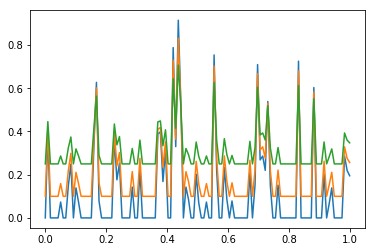

In [58]:
#Unable to do that since PLM is too slow : We simulated PLM data using the TF IDF one.
#We simulate the smoothing to see how it inflences the data

import matplotlib.pyplot as plt
stdout = executeTrecEval("tf_idf",False)
data = getData(str(stdout),["ndcg_cut_10"])
data_array=[]
for i in range(len(data)-1):
    data_array.append(float(data[i][2]))
x=np.linspace(0,1,len(data_array))


def simulate_smoothing(prob,strengh=0.2):
    if prob<0.5:
        return (prob+(0.5-prob)*strengh)
    else:
        return (prob-(prob-0.5)*strengh)

data_array_sm=[]
for i in range(len(data)-1):
    data_array_sm.append(simulate_smoothing(float(data[i][2]),0.2))

data_array_sm2=[]
for i in range(len(data)-1):
    data_array_sm2.append(simulate_smoothing(float(data[i][2]),0.5))
plt.plot(x,data_array,x,data_array_sm,x,data_array_sm2)
plt.show()


5) Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[10 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.


In [16]:
def runttest(method1,method2,measure):
    stdout1 = executeTrecEval(method1,False)
    data1 = getData(str(stdout1),[measure])
    stdout2 = executeTrecEval(method2,False)
    data2 = getData(str(stdout2),[measure])
    data_array_1=[]
    data_array_2=[]
    for i in range(len(data1)-1):
        data_array_1.append(float(data1[i][2]))
    for j in range(len(data2)-1):
        data_array_2.append(float(data2[j][2]))
    return stats.ttest_rel(data_array_1,data_array_2),len(data_array_1)

In [67]:
import scipy as sc
import scipy.stats as stats

filenames=["tf_idf","BM25",("jelineM_"+str(tuned_lambda)),("dirichlet_prior_"+str(tuned_mu)),
           ("absolute_discount_"+str(tuned_delta))]
measures=["ndcg_cut_10","map_cut_1000","P_5","recall_1000"]

for i in range(0,len(filenames)):
    for j in range(i+1,len(filenames)):
        for k in range(len(measures)):
            test_res,data_length= runttest(filenames[i],filenames[j],measures[k])
            p_value=str(test_res[1])
            hypo_valid= float(p_value) < 0.05/data_length
            print(filenames[i],filenames[j],measures[k],"\t\tp_value: "+str(p_value),"\t correlation: "+ str(hypo_valid))

NameError: name 'tuned_lambda' is not defined

6) Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences.

__TODO: see report __

absolute discount seems better on ndcg
query 105, 191 ndcg: "Black Monday" , Efforts to Improve U.S. Schooling
query 76 map cut : U.S. Constitution - Original Intent
query 70 p_5: Surrogate Motherhood
recall 1000: 112 Funding Biotechnology

### Task 2: Latent Semantic Models (LSMs) [25 points + 10 bonus points] ###

In this task you will experiment with applying a distributional semantics methods ([word2vec](http://arxiv.org/abs/1411.2738)  **[5 points]**, [LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]**, [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]** and [doc2vec](https://cs.stanford.edu/~quocle/paragraph_vector.pdf) **[5 points]**) for retrieval.

You do not need to implement word2vec, LSI, LDA and doc2vec on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html) (pre-loaded on the VirtualBox). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. For example, in the case of word2vec, you only have vectors for individual words and not for documents or phrases. Try one of the following methods for producing these representations:
   * Average or sum the word vectors.
   * Cluster words in the document using [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and use the centroid of the most important cluster. Experiment with different values of K for k-means.
   * Using the [bag-of-word-embeddings representation](https://ciir-publications.cs.umass.edu/pub/web/getpdf.php?id=1248). **[10 bonus points]**
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

##### Pre Processing

In [100]:
# getting 1000 documents given query for task 2
scores = {}
prog = 0
for query_id, term_id_list in query_dict.items():
    scores[query_id] = []
    document_set=set()
    for term_id in term_id_list:
        #document_set = document_set | set(term_to_doc[term_id])
    for document_id in document_set:
        temp_res = 0
        for term_id in term_id_list:
            temp_res += TF_IDF(term_id,document_id)
        scores[query_id].append((temp_res,index.document(document_id)[0],document_id))

In [101]:
tf_idf_scores = {}
for key in scores:
    tf_idf_scores[key] = []
    for elem in scores[key]:
        lst = list(elem)
        lst = lst[:-1]
        tf_idf_scores[key].append(tuple(lst))

In [102]:
# sort the result and get the 1000 first documents
from operator import itemgetter
sorted_query_doc = {}
for query_id, term_id_list in query_dict.items():
    sorted_query_doc[query_id] = sorted(scores[query_id],key=itemgetter(0), reverse=True)
    del sorted_query_doc[query_id][1000:]

In [17]:
# prepare documents
import copy
import gensim
import logging
import pyndri
import pyndri.compat
import sys

logging.info('Loading vocabulary.')
doc = index.document(index.document_base())
dictionary = pyndri.extract_dictionary(index)
sentences = pyndri.compat.IndriSentences(index, dictionary)

logging.info('Constructing word2vec vocabulary.')

##### Word2Vec

In [59]:
# TAKES A LOT OF TIME. I SAVED THE TRAINED MODEL ON DISK
# WORD2VEC, sentences == documents in collections
logging.basicConfig(level=logging.INFO)

logging.info('Initializing word2vec.')

word2vec_init = gensim.models.Word2Vec(
    size=32,  # Embedding size
    window=20,  # One-sided window size
    sg=False,  # Skip-gram.
    min_count=5,  # Minimum word frequency.
    sample=1e-3,  # Sub-sample threshold.
    hs=True,  # Hierarchical softmax.
    negative=10,  # Number of negative examples.
    iter=1,  # Number of iterations.
    workers=8,  # Number of workers.
)

word2vec_init.build_vocab(sentences, trim_rule=None)

models = [word2vec_init]
for epoch in range(1, 5 + 1):
    logging.info('Epoch %d', epoch)

    model = copy.deepcopy(models[-1])
    model.train(sentences)

    models.append(model)

logging.info('Trained models: %s', models)

In [60]:
# save trained model to disk
model.save("c-bow_32embeddings_20w.model")

In [74]:
# load existing model from disk
model1 = gensim.models.Word2Vec.load("skip-gram_32embeddings.model")

In [75]:
model2 = gensim.models.Word2Vec.load("skip-gram_32embeddings_10w.model")

In [76]:
model3 = gensim.models.Word2Vec.load("c-bow_32embeddings_5w.model")

In [77]:
model4 = gensim.models.Word2Vec.load("c-bow_32embeddings_10w.model")

In [78]:
model5 = gensim.models.Word2Vec.load("skip-gram_32embeddings_20w.model")

In [79]:
model6 = gensim.models.Word2Vec.load("c-bow_32embeddings_20w.model")

In [80]:
models = []
models.append(model1)
models.append(model2)
models.append(model3)
models.append(model4)
models.append(model5)
models.append(model6)

In [109]:
print(model6['berlin'])

[-0.60421854 -0.68170458  2.28527284  4.61854267  0.77894145  0.08169445
  4.18857861  2.2598176  -0.45265454  3.06660676  1.17877984  2.3091619
  0.44742432  0.61538821  1.618083   -2.26365852  6.51849461  2.39608955
  0.85915774  0.21485458 -2.96822262 -1.661816    1.48785543  0.35060275
 -6.09085512 -3.37793469 -0.08213536 -2.82506061 -1.5680027  -4.01613569
  0.83668733 -1.86140358]


In [111]:
from scipy import spatial
from scipy import stats
# create representation of query and documents with averaging the vectors 
def run_word2vec(model): 
    word2vec_cosine_sim = {}
    doc_representation = {}
    for query_id, term_id_list in query_dict.items():
        word2vec_cosine_sim[query_id] = []
        word2vec_kl_div[query_id] = []
        q = np.zeros(32) # 32 is the size of the embeddings
        for term_id in term_id_list:
            # ignore common words and word that appears less than 5 times in the whole collection
            if term_id > 0 and id2token[term_id] in model :
                q = np.add(q, model[id2token[term_id]])
        q /= len(term_id_list)
        for res in sorted_query_doc[query_id]:
            doc_id = res[2]
            d = np.zeros(32)
            # store doc representation in dictionary, don't have to calculate if it's already calculated before
            if doc_id not in doc_representation:
                doc = index.document(doc_id)
                for word_id in doc[1]:
                    # ignore common words and word that appears less than 5 times in the whole collection
                    if word_id > 0 and id2token[word_id] in model:
                        d = np.add(d, model[id2token[word_id]])
                d /= len(doc[1])
                doc_representation[doc_id] = d
            word2vec_cosine_sim[query_id].append((1 - spatial.distance.cosine(q,doc_representation[doc_id]),index.document(doc_id)[0])) 
    return word2vec_cosine_sim

In [113]:
# DO NOT RUN, IT WILL REWRITE THE PREVIOUS RUN FILE

models_name = ['sg_5','sg_10','cbow_5','cbow_10','sg_20','cbow_20']
for i in range(len(models)):
    word2vec_cosine_sim = run_word2vec(models[i])
    print("finish model")
    write_run(model_name='word2vec_cosine_' + models_name[i],
          data=word2vec_cosine_sim,out_f=open('./ap_88_89/word2vec_cosine_' + models_name[i] +'.run', 'w'),max_objects_per_query=1000)

finish model
finish model
finish model
finish model
finish model
finish model


In [89]:
import os
from subprocess import Popen, PIPE, CalledProcessError

models_name = ['sg_5','sg_10','cbow_5','cbow_10','sg_20','cbow_20']
list_mean_hyperparams=[]
filename= "word2vec_cosine_"
for i in range(len(models_name)):
    stdout = executeTrecEval(filename+str(models_name[i]),True)
    list_mean_hyperparams.append(getMean(getData(str(stdout),["P_1000","recall_1000","ndcg"])))
tuned_hyperparams = models_name[whoWins(list_mean_hyperparams)]
print("Best lambda for word2vec_cosine_sim ",tuned_hyperparams)

Best lambda for word2vec_cosine_sim  cbow_20


##### Another Pre Processing (for LSI and LDA)

In [18]:
# corpus preparation for LSI and LDA model, reading all the documents in the collection
dictionary = gensim.corpora.Dictionary(sentences)

In [19]:
# creating bag of words representation for each document in the collection (ordered sequentially)
corpus = [dictionary.doc2bow(sentence) for sentence in sentences]

In [20]:
# creating bag of words representation for each query in the collection (ordered sequentially)
query_corpus = []
for query_id, term_id_list in query_dict.items():
    term_word = [id2token[term_id] for term_id in term_id_list]
    query_corpus.append(dictionary.doc2bow(term_word))

In [60]:
# in case for storing file to disk
import pickle
def dump_file(obj,filename):
    pickle.dump(obj, open(filename, 'wb'))
    
def read_file(filename):
    return pickle.load(open('filename', 'rb'))

##### LSI

In [66]:
# train LSI Model and create a 10 topic representation for document and a query
# TAKES A LOT OF TIME
lsi_model = gensim.models.LsiModel(corpus, id2word=dictionary, num_topics=10)
doc_lsi_representation = lsi_model[corpus]
query_lsi_representation = lsi_model[query_corpus]

In [34]:
lsi_model = gensim.models.LsiModel.load("lsi_10.model")
doc_lsi_representation = lsi_model[corpus]
query_lsi_representation = lsi_model[query_corpus]

In [35]:
# create representation of doc_model and its doc_id
doc_corpus_with_id = {}
for doc_rep, document_id in zip(doc_lsi_representation, range(index.document_base(), index.maximum_document())):
    doc_corpus_with_id[document_id] = doc_rep

In [67]:
lsi_model.save("lsi_10.model")

In [36]:
# convert doc or query from tuple representation (topic_id, score) to only vector of scores 
def convert2vec(rep):
    vec = [elem[1] for elem in rep]
    return np.array(vec)

In [37]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import mutual_info_score 
lsi_cosine_sim = {}
lsi_kl_div = {}
# create representation of query and documents with averaging the vectors 
for query, q_rep in zip(query_dict.items(), query_lsi_representation):
    lsi_cosine_sim[query[0]] = []
    lsi_kl_div[query[0]] = []
    q = convert2vec(q_rep)
    for res in sorted_query_doc[query[0]]:
        doc_id = res[2]
        d_rep = doc_corpus_with_id[doc_id]
        d = convert2vec(d_rep)
        lsi_cosine_sim[query[0]].append((cosine_similarity(q.reshape(1,-1),d.reshape(1,-1))[0][0],index.document(doc_id)[0])) 
        lsi_kl_div[query[0]].append((mutual_info_score(q,d),index.document(doc_id)[0])) 

##### LDA

In [68]:
# train LSI Model and create a 10 topic representation for document and a query
# TAKES A LOT OF TIME
lda_model = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=10)
doc_lda_representation = lda_model[corpus]
query_lda_representation = lda_model[query_corpus]

In [41]:
lda_model = gensim.models.LdaModel.load("lda_10.model")
doc_lda_representation = lda_model[corpus]
query_lda_representation = lda_model[query_corpus]

In [42]:
# create representation of doc_model and its doc_id
doc_corpus_with_id_lda = {}
for doc_rep, document_id in zip(doc_lda_representation, range(index.document_base(), index.maximum_document())):
    doc_corpus_with_id_lda[document_id] = doc_rep

In [69]:
lda_model.save("lda_10.model")

In [43]:
def convert2vec_lda(rep):
    vec = [0.0] * 10
    for elem in rep:
        vec[elem[0]] = elem[1]
    return np.array(vec)

In [91]:
print(doc_corpus_with_id_lda[52])
print(query_lda_representation[4])

[(1, 0.29394593628567878), (5, 0.35803121652693637), (6, 0.34141772007474525)]
[(0, 0.88748875304359576), (1, 0.012500821494586945), (2, 0.012500500392128929), (3, 0.012501617173182152), (4, 0.012500382703892943), (5, 0.012504427668192927), (6, 0.012500567887173493), (7, 0.012500272183788122), (8, 0.012501192306339573), (9, 0.012501465147119164)]


In [44]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import mutual_info_score 
lda_cosine_sim = {}
lda_kl_div = {}
# create representation of query and documents with averaging the vectors 
for query, q_rep in zip(query_dict.items(), query_lda_representation):
    lda_cosine_sim[query[0]] = []
    lda_kl_div[query[0]] = []
    q = convert2vec_lda(q_rep)
    for res in sorted_query_doc[query[0]]:
        doc_id = res[2]
        d_rep = doc_corpus_with_id_lda[doc_id]
        d = convert2vec_lda(d_rep)
        lda_cosine_sim[query[0]].append((cosine_similarity(q.reshape(1,-1),d.reshape(1,-1))[0][0],index.document(doc_id)[0])) 
        lda_kl_div[query[0]].append((mutual_info_score(q,d),index.document(doc_id)[0])) 

#### Doc2Vec

In [40]:
# create a doc2vec training data with sentences and its labels
doc2vec_sentence = []
for sentence, doc_id in zip(sentences, range(index.document_base(), index.maximum_document())):
    doc = index.document(doc_id)
    doc2vec_sentence.append(gensim.models.doc2vec.LabeledSentence(list(sentence), [doc[0]]))

In [45]:
# TAKES A LOT OF TIME. I SAVED THE TRAINED MODEL ON DISK
logging.basicConfig(level=logging.INFO)

logging.info('Initializing doc2vec.')

doc2vec_init = gensim.models.Doc2Vec(
    size=32,  # Embedding size
    window=5,  # One-sided window size
    min_count=5,  # Minimum word frequency.
    sample=1e-3,  # Sub-sample threshold.
    hs=False,  # Hierarchical softmax.
    negative=10,  # Number of negative examples.
    iter=1,  # Number of iterations.
    workers=8,  # Number of workers.
    )

doc2vec_init.build_vocab(doc2vec_sentence)

doc2vec_models = [doc2vec_init]
for epoch in range(1, 5 + 1):
    logging.info('Epoch %d', epoch)

    doc2vec_model = copy.deepcopy(doc2vec_models[-1])
    doc2vec_model.train(doc2vec_sentence)

    doc2vec_models.append(doc2vec_model)

logging.info('Trained models: %s', doc2vec_models)

In [46]:
# save trained model to disk
doc2vec_model.save("doc2vec_32embeddings.model")

In [46]:
# load existing model from disk
doc2vec_model = gensim.models.Word2Vec.load("doc2vec_32embeddings.model")

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import mutual_info_score 
doc2vec_cosine_sim = {}
doc2vec_kl_div = {}
# create representation of query and documents with averaging the vectors 
doc_representation = {}
for query_id, term_id_list in query_dict.items():
    doc2vec_cosine_sim[query_id] = []
    doc2vec_kl_div[query_id] = []
    q = np.zeros(32) # 32 is the size of the embeddings
    for term_id in term_id_list:
        # ignore common words and word that appears less than 5 times in the whole collection
        if term_id > 0 and id2token[term_id] in model :
            q = np.add(q, doc2vec_model[id2token[term_id]])
    q /= len(term_id_list)
    for res in sorted_query_doc[query_id]:
        doc_id = res[2]
        d = np.zeros(32) 
        # store doc representation in dictionary, don't have to calculate if it's already calculated before
        if doc_id not in doc_representation:
            doc = index.document(doc_id)
            for word_id in doc[1]:
                # ignore common words and word that appears less than 5 times in the whole collection
                if word_id > 0 and id2token[word_id] in model:
                    d = np.add(d, doc2vec_model[id2token[word_id]])
            d /= len(doc[1])
            doc_representation[doc_id] = d
        doc2vec_cosine_sim[query_id].append((cosine_similarity(q.reshape(1,-1),doc_representation[doc_id].reshape(1,-1))[0][0],index.document(doc_id)[0])) 
        doc2vec_kl_div[query_id].append((mutual_info_score(q,doc_representation[doc_id]),index.document(doc_id)[0])) 

#### Evaluation

In [104]:
write_run(model_name='tf_idf',
          data=tf_idf_scores,out_f=open('./ap_88_89/tf_idf_task_2.run', 'w'),max_objects_per_query=1000)

In [30]:
write_run(model_name='word2vec_cosine',
          data=word2vec_cosine_sim,out_f=open('./ap_88_89/word2vec_cosine.run', 'w'),max_objects_per_query=1000)
write_run(model_name='word2vec_kl_div',
          data=word2vec_kl_div,out_f=open('./ap_88_89/word2vec_kl_div.run', 'w'),max_objects_per_query=1000)

In [38]:
write_run(model_name='lsi_cosine',
          data=lsi_cosine_sim,out_f=open('./ap_88_89/lsi_cosine.run', 'w'),max_objects_per_query=1000)
write_run(model_name='lsi_kl_div',
          data=lsi_kl_div,out_f=open('./ap_88_89/lsi_kl_div.run', 'w'),max_objects_per_query=1000)

In [45]:
write_run(model_name='lda_cosine',
          data=lda_cosine_sim,out_f=open('./ap_88_89/lda_cosine.run', 'w'),max_objects_per_query=1000)
write_run(model_name='lda_kl_div',
          data=lda_kl_div,out_f=open('./ap_88_89/lda_kl_div.run', 'w'),max_objects_per_query=1000)

In [48]:
write_run(model_name='doc2vec_cosine',
          data=doc2vec_cosine_sim,out_f=open('./ap_88_89/doc2vec_cosine.run', 'w'),max_objects_per_query=1000)
write_run(model_name='doc2vec_kl_div',
          data=doc2vec_kl_div,out_f=open('./ap_88_89/doc2vec_kl_div.run', 'w'),max_objects_per_query=1000)

In [91]:
#display measures
#best : word2vec_cosine_cbow_20 and word2vec_kl_div_sg_20
filenames=["word2vec_cosine_cbow_20","word2vec_kl_div_cbow_10","tf_idf_task_2","lsi_cosine","lsi_kl_div","lda_cosine","lda_kl_div",
          "doc2vec_cosine","doc2vec_kl_div"]
nb_files = len(filenames)
#ndcg_cut_10 , map_cut_1000, P_5, recall_1000
#generate the results and store them in a table
tab_result=[]
for file_num in range(len(filenames)):
    filename=filenames[file_num]
    stdout = executeTrecEval(filename,False)
    data = getData(str(stdout),["ndcg_cut_10","map_cut_1000","P_5","recall_1000"])
    for i in range(len(data)):
        foundQuery=False
        for j in range(len(tab_result)):
            if tab_result[j][0]==data[i][0]:
                if(tab_result[j][1]==data[i][1]):
                    foundQuery=True
                    tab_result[j][2+file_num]=str(data[i][2])
                    break
        if not foundQuery:
            tab_result.append([])
            for k in range(nb_files+2):
                tab_result[len(tab_result)-1].append("")
            tab_result[len(tab_result)-1][0]=data[i][0]
            tab_result[len(tab_result)-1][1]=data[i][1]
            tab_result[len(tab_result)-1][2+file_num]=data[i][2]

#create a readable string 
res_s="measure\tquery"
for filename in filenames:
    res_s+="   "+filename
res_s+="\n"
for line in tab_result:
    for i in range(len(line)):
        element= line[i]
        shift = "\t"
        if i==0 and line[0]=="P_5" : 
            shift+="\t"
        if i==4 : 
            shift+="\t"
        if i==5 : 
            shift+="\t"+"\t"
        res_s+=element+shift
    res_s+="\n"
print(res_s)

measure	query   word2vec_cosine_cbow_20   word2vec_kl_div_cbow_10   tf_idf_task_2   lsi_cosine   lsi_kl_div   lda_cosine   lda_kl_div   doc2vec_cosine   doc2vec_kl_div
ndcg_cut_10	100	0.0000	0.0000	0.0000		0.0000			0.0000	0.0000	0.0000	0.0000	0.0000	
ndcg_cut_10	101	0.0784	0.0000	0.0000		0.0000			0.0000	0.0000	0.0000	0.0948	0.0000	
ndcg_cut_10	102	0.0000	0.0000	0.0000		0.0000			0.0000	0.0000	0.0000	0.0000	0.0000	
ndcg_cut_10	104	0.3301	0.0000	0.0000		0.0000			0.0000	0.0000	0.0000	0.3149	0.0000	
ndcg_cut_10	105	0.0000	0.0000	0.0000		0.0000			0.0000	0.0000	0.0000	0.0000	0.0000	
ndcg_cut_10	106	0.0000	0.0000	0.0000		0.0000			0.0000	0.0000	0.0000	0.0000	0.0000	
ndcg_cut_10	107	0.2201	0.0000	0.0000		0.0000			0.0000	0.0000	0.0000	0.2201	0.0000	
ndcg_cut_10	108	0.0663	0.0000	0.0000		0.1100			0.0000	0.4265	0.0000	0.0636	0.0000	
ndcg_cut_10	109	0.0000	0.0000	0.0000		0.0000			0.0000	0.0000	0.0000	0.0000	0.0000	
ndcg_cut_10	110	0.4888	0.0000	0.0000		0.0000			0.0000	0.0000	0.0000	0.3152	0.0000	
nd

In [93]:
#Perform t-test measure : This is going to generate a HUGE amount of data 
filenames=["word2vec_cosine_cbow_20","word2vec_kl_div_sg_20","tf_idf_task_2","lsi_cosine","lsi_kl_div","lda_cosine","lda_kl_div"]
measures=["ndcg_cut_10","map_cut_1000","P_5","recall_1000"]
import scipy.stats as stats
p_value = 0.01

for i in range(0,len(filenames)):
    for j in range(i+1,len(filenames)):
        for k in range(len(measures)):
            test_res,data_length= runttest(filenames[i],filenames[j],measures[k])
            p_value=str(test_res[1])
            hypo_valid= float(p_value) < 0.05/data_length
            print(filenames[i],filenames[j],measures[k],"\t\tp_value: "+str(p_value),"\t correlation: "+ str(hypo_valid))

word2vec_cosine_cbow_20 word2vec_kl_div_sg_20 ndcg_cut_10 		p_value: 8.66928579822e-14 	 correlation: True
word2vec_cosine_cbow_20 word2vec_kl_div_sg_20 map_cut_1000 		p_value: 0.000288105803853 	 correlation: True
word2vec_cosine_cbow_20 word2vec_kl_div_sg_20 P_5 		p_value: 2.38646122055e-12 	 correlation: True


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


word2vec_cosine_cbow_20 word2vec_kl_div_sg_20 recall_1000 		p_value: nan 	 correlation: False
word2vec_cosine_cbow_20 tf_idf_task_2 ndcg_cut_10 		p_value: 2.09099011317e-13 	 correlation: True
word2vec_cosine_cbow_20 tf_idf_task_2 map_cut_1000 		p_value: 0.000268970378141 	 correlation: True
word2vec_cosine_cbow_20 tf_idf_task_2 P_5 		p_value: 4.81032143231e-12 	 correlation: True


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


word2vec_cosine_cbow_20 tf_idf_task_2 recall_1000 		p_value: nan 	 correlation: False
word2vec_cosine_cbow_20 lsi_cosine ndcg_cut_10 		p_value: 6.30088717406e-14 	 correlation: True
word2vec_cosine_cbow_20 lsi_cosine map_cut_1000 		p_value: 0.000130167612924 	 correlation: True
word2vec_cosine_cbow_20 lsi_cosine P_5 		p_value: 3.86923832176e-12 	 correlation: True


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


word2vec_cosine_cbow_20 lsi_cosine recall_1000 		p_value: nan 	 correlation: False
word2vec_cosine_cbow_20 lsi_kl_div ndcg_cut_10 		p_value: 8.66928579822e-14 	 correlation: True
word2vec_cosine_cbow_20 lsi_kl_div map_cut_1000 		p_value: 0.000288105803853 	 correlation: True
word2vec_cosine_cbow_20 lsi_kl_div P_5 		p_value: 2.38646122055e-12 	 correlation: True


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


word2vec_cosine_cbow_20 lsi_kl_div recall_1000 		p_value: nan 	 correlation: False
word2vec_cosine_cbow_20 lda_cosine ndcg_cut_10 		p_value: 1.620077199e-12 	 correlation: True
word2vec_cosine_cbow_20 lda_cosine map_cut_1000 		p_value: 0.000178193426841 	 correlation: True
word2vec_cosine_cbow_20 lda_cosine P_5 		p_value: 1.88590103773e-11 	 correlation: True


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


word2vec_cosine_cbow_20 lda_cosine recall_1000 		p_value: nan 	 correlation: False
word2vec_cosine_cbow_20 lda_kl_div ndcg_cut_10 		p_value: 3.81464466197e-14 	 correlation: True
word2vec_cosine_cbow_20 lda_kl_div map_cut_1000 		p_value: 0.00027086199673 	 correlation: True
word2vec_cosine_cbow_20 lda_kl_div P_5 		p_value: 1.9475436138e-12 	 correlation: True


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


word2vec_cosine_cbow_20 lda_kl_div recall_1000 		p_value: nan 	 correlation: False
word2vec_kl_div_sg_20 tf_idf_task_2 ndcg_cut_10 		p_value: 0.483618944773 	 correlation: False
word2vec_kl_div_sg_20 tf_idf_task_2 map_cut_1000 		p_value: 0.672140803533 	 correlation: False
word2vec_kl_div_sg_20 tf_idf_task_2 P_5 		p_value: 0.416497812752 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


word2vec_kl_div_sg_20 tf_idf_task_2 recall_1000 		p_value: nan 	 correlation: False
word2vec_kl_div_sg_20 lsi_cosine ndcg_cut_10 		p_value: 0.0240274418108 	 correlation: False
word2vec_kl_div_sg_20 lsi_cosine map_cut_1000 		p_value: 0.170326477856 	 correlation: False
word2vec_kl_div_sg_20 lsi_cosine P_5 		p_value: 0.0189913551926 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


word2vec_kl_div_sg_20 lsi_cosine recall_1000 		p_value: nan 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


word2vec_kl_div_sg_20 lsi_kl_div ndcg_cut_10 		p_value: nan 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


word2vec_kl_div_sg_20 lsi_kl_div map_cut_1000 		p_value: nan 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


word2vec_kl_div_sg_20 lsi_kl_div P_5 		p_value: nan 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


word2vec_kl_div_sg_20 lsi_kl_div recall_1000 		p_value: nan 	 correlation: False
word2vec_kl_div_sg_20 lda_cosine ndcg_cut_10 		p_value: 0.0205855299345 	 correlation: False
word2vec_kl_div_sg_20 lda_cosine map_cut_1000 		p_value: 0.0192687769348 	 correlation: False
word2vec_kl_div_sg_20 lda_cosine P_5 		p_value: 0.0118139103265 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


word2vec_kl_div_sg_20 lda_cosine recall_1000 		p_value: nan 	 correlation: False
word2vec_kl_div_sg_20 lda_kl_div ndcg_cut_10 		p_value: 0.406039545413 	 correlation: False
word2vec_kl_div_sg_20 lda_kl_div map_cut_1000 		p_value: 0.788452876053 	 correlation: False
word2vec_kl_div_sg_20 lda_kl_div P_5 		p_value: 1.0 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


word2vec_kl_div_sg_20 lda_kl_div recall_1000 		p_value: nan 	 correlation: False
tf_idf_task_2 lsi_cosine ndcg_cut_10 		p_value: 0.151322359867 	 correlation: False
tf_idf_task_2 lsi_cosine map_cut_1000 		p_value: 0.165275275538 	 correlation: False
tf_idf_task_2 lsi_cosine P_5 		p_value: 0.166470049899 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


tf_idf_task_2 lsi_cosine recall_1000 		p_value: nan 	 correlation: False
tf_idf_task_2 lsi_kl_div ndcg_cut_10 		p_value: 0.483618944773 	 correlation: False
tf_idf_task_2 lsi_kl_div map_cut_1000 		p_value: 0.672140803533 	 correlation: False
tf_idf_task_2 lsi_kl_div P_5 		p_value: 0.416497812752 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


tf_idf_task_2 lsi_kl_div recall_1000 		p_value: nan 	 correlation: False
tf_idf_task_2 lda_cosine ndcg_cut_10 		p_value: 0.0455046772068 	 correlation: False
tf_idf_task_2 lda_cosine map_cut_1000 		p_value: 0.0272778261886 	 correlation: False
tf_idf_task_2 lda_cosine P_5 		p_value: 0.0590364800096 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


tf_idf_task_2 lda_cosine recall_1000 		p_value: nan 	 correlation: False
tf_idf_task_2 lda_kl_div ndcg_cut_10 		p_value: 0.220853221955 	 correlation: False
tf_idf_task_2 lda_kl_div map_cut_1000 		p_value: 0.714913857691 	 correlation: False
tf_idf_task_2 lda_kl_div P_5 		p_value: 0.481799827024 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


tf_idf_task_2 lda_kl_div recall_1000 		p_value: nan 	 correlation: False
lsi_cosine lsi_kl_div ndcg_cut_10 		p_value: 0.0240274418108 	 correlation: False
lsi_cosine lsi_kl_div map_cut_1000 		p_value: 0.170326477856 	 correlation: False
lsi_cosine lsi_kl_div P_5 		p_value: 0.0189913551926 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


lsi_cosine lsi_kl_div recall_1000 		p_value: nan 	 correlation: False
lsi_cosine lda_cosine ndcg_cut_10 		p_value: 0.288263902642 	 correlation: False
lsi_cosine lda_cosine map_cut_1000 		p_value: 0.031962020952 	 correlation: False
lsi_cosine lda_cosine P_5 		p_value: 0.407650993638 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


lsi_cosine lda_cosine recall_1000 		p_value: nan 	 correlation: False
lsi_cosine lda_kl_div ndcg_cut_10 		p_value: 0.011768709545 	 correlation: False
lsi_cosine lda_kl_div map_cut_1000 		p_value: 0.166956156643 	 correlation: False
lsi_cosine lda_kl_div P_5 		p_value: 0.0518097530765 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


lsi_cosine lda_kl_div recall_1000 		p_value: nan 	 correlation: False
lsi_kl_div lda_cosine ndcg_cut_10 		p_value: 0.0205855299345 	 correlation: False
lsi_kl_div lda_cosine map_cut_1000 		p_value: 0.0192687769348 	 correlation: False
lsi_kl_div lda_cosine P_5 		p_value: 0.0118139103265 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


lsi_kl_div lda_cosine recall_1000 		p_value: nan 	 correlation: False
lsi_kl_div lda_kl_div ndcg_cut_10 		p_value: 0.406039545413 	 correlation: False
lsi_kl_div lda_kl_div map_cut_1000 		p_value: 0.788452876053 	 correlation: False
lsi_kl_div lda_kl_div P_5 		p_value: 1.0 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


lsi_kl_div lda_kl_div recall_1000 		p_value: nan 	 correlation: False
lda_cosine lda_kl_div ndcg_cut_10 		p_value: 0.0119946941937 	 correlation: False
lda_cosine lda_kl_div map_cut_1000 		p_value: 0.0171916144876 	 correlation: False
lda_cosine lda_kl_div P_5 		p_value: 0.0247194319233 	 correlation: False
lda_cosine lda_kl_div recall_1000 		p_value: nan 	 correlation: False


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail


### To Do:
- implement bag of words embeddings for the vector
- hyperparameter tuning ? 

### Task 3: Learning to rank (LTR) [10 points] ###

In this task you will get an introduction into learning to rank for information retrieval. You will experiment with a pointwise learning to rank method, logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

**NOTE**: you can only perform this task if you have completely finished Task 1 and Task 2.

In this experiment, you will use the retrieval methods you implemented in Task 1 and Task 2 as features for the learning to rank model. Train your LTR model using 10-fold cross validation on the test set. For every query, first create a document candidate set using the top-1000 documents using TF-IDF. Secondly, compute query-document values using the retrieval models above and use them as features. Note that the feature values of different retrieval methods are likely to be distributed differently.

Your approach will definitely not be as good as the state-of-the-art since you are taking a pointwise approach, but we do not ask you to try pair- or listwise methods because they will be the main topic of the next assignment.

In [ ]:
# preprocessing for LSI or LDA model if you haven't run it in task 2, this going to take a while
# DO NOT RUN IF YOU ALREADY RUN IT IN TASK 2
dictionary = gensim.corpora.Dictionary(sentences)
corpus = [dictionary.doc2bow(sentence) for sentence in sentences]
query_corpus = []
for query_id, term_id_list in query_dict.items():
    term_word = [id2token[term_id] for term_id in term_id_list]
    query_corpus.append(dictionary.doc2bow(term_word))

In [43]:
# function to convert for lsi and lda, no need to run if you have run it in task 2    
def convert2vec(rep):
    vec = np.zeros(10)
    for elem in rep:
        vec[elem[0]] = elem[1]
    return np.array(vec)

In [54]:
# feed model_pick parameter either word2vec, doc2vec, lsi, or lda
def get_vector_representation(model_pick):
    doc_representation = {}
    query_representation = {}
    if model_pick == "word2vec" or model_pick == "doc2vec":
        if model_pick == "word2vec":
            model = gensim.models.Word2Vec.load("skip-gram_32embeddings_20w.model")
        if model_pick == "doc2vec":
            model = gensim.models.Word2Vec.load("doc2vec_32embeddings.model")
        for query_id, term_id_list in query_dict.items():
            q = np.zeros(32) # 32 is the size of the embeddings
            for term_id in term_id_list:
                # ignore common words and word that appears less than 5 times in the whole collection
                if term_id > 0 and id2token[term_id] in model :
                    q = np.add(q, model[id2token[term_id]])
            q /= len(term_id_list)
            query_representation[query_id] = q
        for doc_id in range(index.document_base(), index.maximum_document()) :
            d = np.zeros(32)
            doc = index.document(doc_id)
            for word_id in doc[1]:
                # ignore common words and word that appears less than 5 times in the whole collection
                if word_id > 0 and id2token[word_id] in model:
                    d = np.add(d, model[id2token[word_id]])
            d /= len(doc[1])
            doc_representation[doc[0]] = d
    if model_pick == "lsi" or model_pick == "lda":
        if model_pick == "lsi":
            model = gensim.models.LsiModel.load("lsi_10.model")
        if model_pick == "lda":
            model = gensim.models.LdaModel.load("lda_10.model")
        doc_rep_temp = model[corpus]
        query_rep_temp = model[query_corpus]
        # attach doc id to the representation
        for doc_rep, document_id in zip(doc_rep_temp, range(index.document_base(), index.maximum_document())):
            doc = index.document(document_id)
            doc_representation[doc[0]] = convert2vec(doc_rep)
        # attach query id to the representation
        for query_rep, query in zip(query_rep_temp, query_dict.items()):
            query_representation[query[0]] = convert2vec(query_rep)
    return doc_representation, query_representation

In [58]:
# LDA IS GOING TO TAKE A LOT OF TIME, DONT RUN THIS
d_rep, q_rep = get_vector_representation("word2vec")

In [70]:
# run this for LDA instead
import pickle
d_rep = pickle.load(open("d_rep_lda.dump","rb"))
q_rep = pickle.load(open("q_rep_lda.dump","rb"))

In [73]:
# USAGE : d_rep[doc_id] will return you the vector of its doc_id
print(d_rep["AP880410-0025"])

[ 0.03590848  0.05173832  0.09448165  0.0843263   0.07602705  0.15609604
  0.21276745  0.15617259  0.04630518  0.08617694]


In [ ]:
# get the scores for cosine similarity of 

In [239]:
from operator import itemgetter
        
def getTF_best(query_id,number):
    scores = {}
    term_id_list=query_dict[str(query_id)]
    
    document_set=set()
    for term_id in term_id_list:
        document_set = document_set | set(term_to_doc[term_id])
        for document_id in document_set:
            if(document_id not in scores):
                scores[document_id]=0
            scores[document_id]+=TF_IDF(term_id,document_id)
    scores_list=[]
    for doc_id,sc in scores.items():
        scores_list.append((sc,doc_id))
    
    sorted_query_doc = sorted(scores_list,key=itemgetter(0), reverse=True)
    del sorted_query_doc[int(number):]
    
    features_list=[]
    features_scores=[]
    for pair in sorted_query_doc:
        #TODO: transform pair to vector
        features_list.append((int(query_id),int(pair[1])))#query_id, doc_id
        features_scores.append(pair[0])
    
    return features_list,features_scores
features_list,features_scores=getTF_best(68,10)


In [1]:
from sklearn.linear_model import LogisticRegression

#Train LTR using 10 fold cross validation on test set 
query_doc_data=[]
relevance_data=[]
#qrel_test structure: Query __ doc relevance (68 0 AP880218-0195 1)
#process the data to get the query_id, document_id and relevance. 
with open('./ap_88_89/qrel_test', 'r') as test_data:
    for line in test_data:
        line=line.replace('\n','')
        line_split= line.split(' ')
        query_id=line_split[0]
        doc_id=index.document_ids([line_split[2]])
        #handle documents that have no doc id related: 
        if(len(doc_id)>0):
            relevance= line_split[3]
            #TODO: transform pair to vector
            query_doc_data.append((int(query_id),int(doc_id[0][1])))
            relevance_data.append(relevance)
k=10

#split the queries from qrel_test in 10 equally sized folds
elem_repart=np.linspace(0,len(query_doc_data), num=k+1)[1:k]
query_doc_data_fold= np.split(np.random.permutation(query_doc_data),elem_repart)

elem_repart2=np.linspace(0,len(relevance_data), num=k+1)[1:k]
relevance_data_fold= np.split(np.random.permutation(relevance_data),elem_repart2)

TF_IDF_reranked={}
#10-fold cross validation
for i in range(0,k):
    training_x=[]
    training_y=[]
    for j in range(0,k):
        if j != i :
            for l in range(len(query_doc_data_fold[j])):
                training_x.append(query_doc_data_fold[j][l])
                training_y.append(int(relevance_data_fold[j][l]))
    # train a LTR on the 9 remaining folds
    logreg = LogisticRegression()
    print(training_x[0:10])
    logreg.fit(training_x[0:100],training_y[0:100])
    print(training_y[0:10])
    print(logreg.predict(training_x[0:100]))
    #for every queries in test fold
    for query_id,document_id in query_doc_data_fold[i]:
        if query_id not in TF_IDF_reranked:
            TF_IDF_reranked[query_id]=[]
        #retrieve best 1000 documents using TF-IDF
        features,features_score= getTF_best(query_id,1000)
        prediction_feature= logreg.predict(features)
        for pred in prediction_feature:
            if pred!=0:
                print(pred)
        sort_index = sorted(range(len(prediction_feature)), key=lambda m: prediction_feature[m],reverse=True)
        #Check sort index 
        features= [features[_i] for _i in sort_index]
        features_score= [features_score[_i] for _i in sort_index]
        for n in range(len(features)):
            TF_IDF_reranked[features[n][0]].append((features_score[n],index.document(features[n][1])[0]))
        #STEP 2 ????? 



NameError: name 'index' is not defined

In [ ]:
#write result in file
name= "tf_idf_reranked"
write_run(model_name='tf-idf',data=TF_IDF_reranked,out_f=open('./ap_88_89/'+name+'.run', 'w'),max_objects_per_query=1000)

In [ ]:
#user trec_eval to get score 
#display measures
filenames=["tf_idf_reranked"]
nb_files = len(filenames)
#ndcg_cut_10 , map_cut_1000, P_5, recall_1000
#generate the results and store them in a table
tab_result=[]
for file_num in range(len(filenames)):
    filename=filenames[file_num]
    stdout = executeTrecEval(filename,False)
    data = getData(str(stdout),["ndcg_cut_10","map_cut_1000","P_5","recall_1000"])
    for i in range(len(data)):
        foundQuery=False
        for j in range(len(tab_result)):
            if tab_result[j][0]==data[i][0]:
                if(tab_result[j][1]==data[i][1]):
                    foundQuery=True
                    tab_result[j][2+file_num]=str(data[i][2])
                    break
        if not foundQuery:
            tab_result.append([])
            for k in range(nb_files+2):
                tab_result[len(tab_result)-1].append("")
            tab_result[len(tab_result)-1][0]=data[i][0]
            tab_result[len(tab_result)-1][1]=data[i][1]
            tab_result[len(tab_result)-1][2+file_num]=data[i][2]

#create a readable string 
res_s="measure\tquery"
for filename in filenames:
    res_s+="   "+filename
res_s+="\n"
for line in tab_result:
    for i in range(len(line)):
        element= line[i]
        shift = "\t"
        if i==0 and line[0]=="P_5" : 
            shift+="\t"
        if i==4 : 
            shift+="\t"
        if i==5 : 
            shift+="\t"+"\t"
        res_s+=element+shift
    res_s+="\n"
print(res_s)

### Task 4: Write a report [20 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Do not send us the VirtualBox, but only the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file system structure as on the VirtualBox.
